# Molecular Docking on AutoDock

### This notebook was adapted from the original Lab.06 / IBM3202 – Molecular Docking on AutoDock.
It forms part of a very good bioinformatics series which can be found [here](https://github.com/pb3lab/ibm3202).
This was released under and MIT license.

### Citation:
Engelberger F, Galaz-Davison P, Bravo G, Rivera M, Ramírez-Sarmiento CA (2021) Developing and Implementing Cloud-Based Tutorials that Combine Bioinformatics Software, Interactive Coding and Visualization Exercises for Distance Learning on Structural Bioinformatics. J Chem Educ 98(5): 1801-1807. doi: 10.1021/acs.jchemed.1c00022

<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>



<a rel="license" href="https://opensource.org/licenses/MIT "><img alt="MIT Licence" src="https://img.shields.io/badge/License-MIT-yellow.svg" align="left"/></a>

<br></br>
**Authors**: Engelberger F, Galaz-Davison P, Bravo G, Rivera M, Ramírez-Sarmiento CA   
**Contributor**: Dr Antonia Mey (antonia.mey@ed.ac.uk) and Rohan Gorantla

**Questions:** Can we create a protein-ligand complex from a crystal structure and a smiles string?

**Objectives:**
  - Prepare a protein for docking with Autodock Vina
  - Prepare a series of ligands for Docking
  - Understand docking results by computing RMSDs and comparing scores against experimental results

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

## Google Colab setup

<div class="alert alert-warning">
<b>Attention:</b> Please only run the following cell if you are using Colab! This cell will download the data required for Section 4 of this tutorial.</div>

In [1]:
!if [ -n "$COLAB_RELEASE_TAG" ]; then git clone https://github.com/CCPBioSim/CCP5_Simulation_of_BioMolecules; fi
import os
os.chdir(f"CCP5_Simulation_of_BioMolecules{os.sep}4_Docking")

Cloning into 'CCP5_Simulation_of_BioMolecules'...
remote: Enumerating objects: 388, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 388 (delta 39), reused 51 (delta 26), pack-reused 319
Receiving objects: 100% (388/388), 379.78 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Updating files: 100% (64/64), done.


# Part 0 – Downloading and Installing the required software

The following is for **Google Colab** only!

This tutorial has many dependencies for it to work. They are:
- **biopython** for manipulation of the PDB files
- **py3Dmol** to visualise the protein structure and set up the search grid.
- **miniconda**, a free minimal installer of **conda** for software package and environment management.
- **OpenBabel** for parameterization of our ligand(s).
- **MGLtools** are used to parameterize our target protein using Gasteiger charges.
- **pdb2pqr** for parameterization of our protein using the AMBER ff99 forcefield.
- **Autodock Vina** for the docking process

After several tests, the following installation instructions are the best way of setting up **Google Colab** for this laboratory session.

### 0.1 Setup conda colab

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


### 0.2 Check conda colab works

In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


### 0.3 Install py3D mol for visualisation and pdb2pqr for parametrisation

In [2]:
!pip install py3Dmol
!pip install pdb2pqr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 72.9 MB/s eta 0:00:00


### 0.4 Creating and installing the rest of the environment

In [3]:
# Step 1: Create the env.yml file
env_yaml = """
channels:
  - conda-forge

dependencies:
  - python >= 3.8
  - pip
  - tqdm
  - loguru
  - fsspec
  - s3fs
  - gcsfs
  - joblib

  # Scientific
  - pandas = 2.1
  - numpy
  - scipy

  # Chemistry
  - rdkit
  - datamol
  - openmm >=7.6.0
  - pdbfixer >=1.8
  - openmmforcefields
  - mdtraj
  - mdanalysis

  # Docking
  - openbabel
  - smina
  - qvina
  - fpocket

  # Viz
  - matplotlib
  - ipywidgets = 7.7.2
  - nglview
"""

# Write the environment configuration to a file
with open("environment.yml", "w") as file:
    file.write(env_yaml)


And now we can install the environment we have created using mamba. Please be patient! **The next two cells may take some time to run**.

In [4]:
%%capture
!mamba env update -n base -f environment.yml

In [5]:
%%capture
!mamba install -c conda-forge -c bioconda mgltools openbabel zlib ncurses --yes


Looking for: ['mgltools', 'openbabel', 'zlib', 'ncurses']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
bioconda/linux-64 ..  ⣾  bioconda/linux-64 (check zst)                     
[+] 0.0s
bioconda/noarch (check zst)                        Checked  0.1s
[+] 0.0s
[+] 0.1s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.2s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.3s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.4s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.5s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.6s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.7s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.8s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 0.9s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 1.0s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  [+] 1.1s
bioconda/linux-64  ⣾  
bioconda/noarch    ⣾  bioconda/linux-64        

In [6]:
# Importing py3Dmol for safety
import py3Dmol

In [7]:
# Checking that pdb2pqr was properly installed
!pdb2pqr30 -h | awk 'NR==1{if($1=="usage:") print "PDB2PQR succesfully installed"; else if($1!="usage:") print "Something went wrong. Please install again"}'

PDB2PQR succesfully installed


### 0.5 Autodock Vina
Finally, we will download the Autodock Vina program from the [AutoDock Vina GitHub](https://github.com/ccsb-scripps/AutoDock-Vina) and make an alias to use it during this session

In [8]:
# Download and extract Autodock Vina from SCRIPPS
# Then, we set up an alias for vina to be treated as a native binary
%%bash
mkdir vina
cd vina
wget -q https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64
chmod +x /content/vina/vina_1.2.5_linux_x86_64
wget -q https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_split_1.2.5_linux_x86_64
chmod +x /content/vina/vina_split_1.2.5_linux_x86_64

In [9]:
%alias vina /content/vina/vina_1.2.5_linux_x86_64
%alias vina_split /content/vina/vina_1.2.5_linux_x86_64

Now you should have a working environment and we can actually start thinking about running docking!

## 1. Theoretical aspects

Many protein structures are determined experimentally using X-ray crystallography or nuclear magnetic resonance (NMR) spectroscopy and computationally through AlphaFold molecular docking, which is an essential tool in **drug discovery**.

**Molecular docking** explores the potential binding poses of small molecules in the **binding site** of a target protein for which reliable atomic coordinates are available.

Thus, the **_druggability_** of different compounds and their binding affinity on a given protein target can be calculated. This can help identify lead compounds from large molecular libraries.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/docking_01.png'/>
<figcaption>FIGURE 1. In molecular docking, binding is evaluated in two steps: A) Energetics of the transition of the unbound states of ligand and target towards the conformations of the bound complex; and B) energetics of protein-ligand binding in these conformations. <br> Huey R et al (2007) <i>J Comput Chem 28(6), 1145-1152.</i></figcaption></center>
</figure>

Molecular docking programs perform a **search algorithm** in which varying conformations of a given ligand, typically generated using Monte Carlo or Genetic algorithms, are recursively evaluated until convergence to an energy minimum is reached. Finally, through an **affinity scoring function**, a ΔG [binding free energy in kcal/mol] is estimated and employed to rank the candidate poses as the sum of several energetic contributions (electrostatics, van der Waals, desolvation, etc).

## 2. Experimental Overview

We will use data from the [protein ligand benchmark dataset](https://github.com/openforcefield/protein-ligand-benchmark) for our docking workshop. In particular, we will use the protein *MCL1* which is a well-established cancer target. To find out more about the protein-ligand benchmark check out the publication on it:   
Hahn, D., Bayly, C., Boby, M. L., Bruce Macdonald, H., Chodera, J., Gapsys, V., Mey, A., Mobley, D., Perez Benito, L., Schindler, C., Tresadern, G. ., & Warren, G. (2022). Best Practices for Constructing, Preparing, and Evaluating Protein-Ligand Binding Affinity Benchmarks [Living Journal of Computational Molecular Science, 4(1), 1497.](https://doi.org/10.33011/livecoms.4.1.1497)

For this workshop we use **MGLtools** (and alternatively **pdb2pqr**) to prepare the target protein files, **OpenBabel** to prepare the ligand files, **AutoDock Vina** for the docking procedure and **py3Dmol** to establish the appropriate search grid configuration and analyze the results.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/docking_02.png' />
<figcaption>FIGURE 2. General steps of molecular docking. First, the target protein and ligand or ligands are parameterized. Then, the system is prepared by setting up the search grid. Once the docking calculation is performed, ligand poses are scored based on a given energy function. Lastly, the computational search is processed and compared against experimental data for validation <br><i>Taken from Pars Silico (en.parssilico.com).</i></figcaption></center>
</figure>

### 2.1 Downloading and Preparing the Receptor for AutoDock

The first step in a molecular docking procedure is to have a structure of a given target protein. While in some cases you may want to use an alphaFold structure, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure.

In such scenario, a given target protein structure is downloaded from the **Protein Data Bank (PDB)** (https://www.rcsb.org/pdb) using a given accession ID. For example, for MCL1 the ID:4HW3 is a good structure with a ligand bound to the protein.

We can download the structure from the PDB using **biopython**:

In [10]:
# Downloading the PDB files using biopython
import os
from Bio.PDB import *
pdbid = ['4hw3']
pdbl = PDBList()
for s in pdbid:
  pdbl.retrieve_pdb_file(s, pdir='.', file_format ="pdb", overwrite=True)
  os.rename("pdb"+s+".ent", s+".pdb")

2. In the case of X-ray diffraction, this experimental strategy does not discriminate between electron density coming from static protein atoms or water molecules, meaning that most protein structures solved by X-ray diffraction also include so-called **crystallographic waters** (check the non-bonded red dots on the protein structure below). These molecules are not important for our particular docking exercise and will remove them. However, water-mediated binding can be important and water molecules may be retained for docking.
<figure>
<center>
<img src='https://github.com/CCPBioSim/CCP5_Simulation_of_BioMolecules/blob/main/4_Docking/resources/4HW3.png?raw=1' />
<figcaption>FIGURE 3. Cartoon representation of MCL1 (PDB accession ID 4hw3), with its N-to-C-terminal residues colored according to order and disorder</i></figcaption></center>
</figure>

  Typically, this can be easily done by extracting all of the lines from the PDB file that start with **"ATOM"**, as this is how all of the atoms that belong to amino and nucleic acid residues are termed. In contrast, the atoms from ligands, water molecules and other non-protein/non-nucleic residues are commonly referred to as **"HETATM"**. Also, the different chains of an oligomer are separated by a **"TER"** string, which is important to keep in our case.

  The following **Python snippet** will first create a folder in which we will store all data related to our molecular docking experiment. Then, it will extract all lines matching the string "ATOM" (for the protein atoms) or "TER" (for the chain separations) into a separate PDB file for further processing. Please take a good look at it.

In [12]:
# This snippet will create a folder called "single-docking" for our experiment
# Then, it will print all "ATOM" and "TER" lines from a given PDB into a new file

from pathlib import Path

# Then, we define the path of the folder we want to create.
# Notice that the HOME folder for a hosted runtime in colab is /content/
singlepath = Path("/content/single-dock/")

# Now, we create the folder using the os.mkdir() command
# The if conditional is just to check whether the folder already exists
# In which case, python returns an error
if os.path.exists(singlepath):
  print("path already exists")
if not os.path.exists(singlepath):
  os.mkdir(singlepath)
  print("path was succesfully created")

# Now we assign a variable "protein" with the name and extension of our pdb
protein = "4hw3.pdb"

# And we use the following script to selectively print the lines that contain the
# string "ATOM" and "TER" into a new file inside our recently created folder
with open(singlepath / "4hw3_prot.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if row[0] == "ATOM":
      g.write(line)
    elif row[0] == "TER":
      g.write("TER\n")
  g.write("END")
  print("file successfully created")

path already exists
file successfully created


3. Once we printed out the "ATOM" lines of the parent PDB file, we have a new file that contains  the coordinates of our target protein.

  However, for AutoDock Vina to perform a molecular docking experiment, the target protein file must contain atom types compatible with Autodock for evaluating different types of interaction, as well as their partial charges to evaluate electrostatic interactions. Such information is included in a file known as **PDBQT**, a modification of the PDB format that also includes **charges (q)** and **AutoDock-specific atom types (t)** in two extra columns at the end of the now PDBQT file. It is worth noting, however, that Autodock Vina **ignores the user-supplied partial charges**, as it has its own way of dealing with electrostatic interactions.

  Lastly, the protein target must contain **all polar hydrogens**, such that hydrogen bonds can be formed between the target protein and the ligand. Most protein structures have no hydrogens included, meaning that we must add them.

  This is the part of the tutorial where you have **two different options** to proceed with your experiment!

3. a) Add the polar hydrogens of your protein and parameterize it with **Gasteiger** charges and atom types using **MGLtools** (this is the canonical option for the majority of AutoDock users)

In [13]:
# Parameterizing and adding Gasteiger charges into our protein using MGLtools
!prepare_receptor4.py -r $singlepath/4hw3_prot.pdb -o $singlepath/4hw3_prot.pdbqt -A hydrogens -U nphs_lps -v

set verbose to  True
read  /content/single-dock/4hw3_prot.pdb
setting up RPO with mode= automatic and outputfilename=  /content/single-dock/4hw3_prot.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


3. b) Add the polar hydrogens of your protein and parameterize it based on the pKa of each aminoacid at pH 7.4 with the **AMBER99ff** force field using **pdb2pqr**, followed by deletion of non-polar hydrogens and conversion into **PDBQT** file using **MGLtools**.

  In this case, pdb2pqr generates an intermediate **PQR** file, a modification of the PDB format which allows users to add charge and radius parameters to existing PDB data. This information is then unaltered during the use of **MGLtools**.

In [14]:
# First, using pdb2pqr to parameterize our receptor with AMBER99ff, maintaining
# the chain IDs and setting up the receptor at a pH of 7.4
!pdb2pqr30 --ff AMBER --keep-chain --titration-state-method propka --with-ph 7.4 $singlepath/4hw3_prot.pdb $singlepath/4hw3_prot.pqr

# Then, convert the .pqr file into a .pdbqt file while deleting non-polar
# hydrogens but without changing the AMBER parameters added to the protein
!prepare_receptor4.py -r $singlepath/4hw3_prot.pqr -o $singlepath/4hw3_prot.pdbqt -C -U nphs_lps -v

INFO:PDB2PQR v3.6.2: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: /content/single-dock/4hw3_prot.pdb
INFO:Setting up molecule.
INFO:Created biomolecule object with 1804 residues and 14358 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 148 missing atoms in biomolecule.
INFO:Added atom CG to residue LYS A 197 at coordinates 62.309, 0.575, 30.452
INFO:Added atom CD to residue LYS A 197 at coordinates 61.432, -0.466, 31.121
INFO:Added atom CE to residue LYS A 197 at coordi

**You are all set with your target protein!**

>Before we move onto preparing the ligand for molecular docking, please consider the following questions:
- Why is it important to add hydrogens for the purposes of our docking simulations?
- Why are we only adding polar hydrogens?
- If the partial charges are ignored by Autodock Vina, how can these different strategies affect my docking results? (this is something you can actually test!)



## 2.2 Preparing the Ligand for AutoDock

1. We now need to prepare the ligand that we will use for our docking analysis. In our case, we will use known inhibitors from the protein-ligand benchmark. We will attempt to predict the docking pose of first one and later multiple inhibitors onto the binding site of MCL1.

We will first start by creating a folder in which we will store our ligands for molecular docking.

In [15]:
# We will first create a path for all ligands that we will use in this tutorial
# Notice that the HOME folder for a hosted runtime in colab is /content/
ligandpath = Path("/content/ligands/")

# Now, we create the folder using the os.mkdir() command
# The if conditional is just to check whether the folder already exists
# In which case, python returns an error
if os.path.exists(ligandpath):
  print("ligand path already exists")
if not os.path.exists(ligandpath):
  os.mkdir(ligandpath)
  print("ligand path was succesfully created")

ligand path was succesfully created


### 2.2.2. Loading the ligand file
One example ligand can be found in `4_Docking/resources/lig27.smi` We will have to read this file. It contains ligand 27 in a SMILES string format.



In [16]:
!cp CCP5_Simulation_of_BioMolecules/4_Docking/resources/lig27.smi /content/ligands/

**But what is a SMILES format?** Well, the **Simplified Molecular-Input Line-Entry System** (SMILES) is a text notation that allows a user to represent a chemical structure in a way that can be used by the computer. The elemental notation for different types of bonds between different atoms is as follows:

  \-	for single bonds (eg. C-C or CC is CH3CH3)

  \=	for double bonds (eg. C=C for CH2CH2)

  \#	for triple bonds (eg. C#N for C≡N)

  \	for aromatic bond (eg. C\*1\*C\*C\*C\*C\*C1 or c1ccccc1 for benzene)

  \. for disconnected structures (eg. Na.Cl for NaCl)

  / and \ for double bond stereoisomers (eg. F/C=C/F for trans-1,2-difluoroethylene and F/C=C\F for cis-1,2-difluoroethylene)

  @ and @@ for enantiomers (eg. N\[C@@H](C)C(=O)O for L-alanine and N\[C@H](C)C(=O)O for D-alanine)

  **Let's take a look at the SMILES of our MCL1 inhibitor, also known as Lig 27!**

In [33]:
#Print the SMILES of Lig 27 to see what it is all about
print((ligandpath / "lig27.smi").read_text())

O=C([O-])c1[nH]c2ccccc2c1CCCOc1ccccc1



In [34]:
# Use the following Viewer to load your SMILES as a 3D molecule
import py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view()
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

from ipywidgets import interact,fixed,IntSlider
import ipywidgets

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

@interact
def smi2viewer(smi='CC=O'):
    try:
        conf = smi2conf(smi)
        return MolTo3DView(conf).show()
    except:
        return None

interactive(children=(Text(value='CC=O', description='smi'), Output()), _dom_classes=('widget-interact',))

#### 2.2.4. Constructing parameters

Now, we will take this SMILES format and use it to construct and parameterize a three-dimensional structure of Lig 27 in **PDBQT** format for its use in molecular docking. As with the receptor, we also have different options to prepare our ligand for molecular docking:

4. a) Use the program **babel** to convert the SMILES into a **MOL2** file without any extra work (such as searching for best conformers) except for setting the protonation state to pH 7.4, and then use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges (this is the canonical option for the majority of AutoDock users). Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [36]:
m = Chem.MolFromSmiles('O=C([O-])c1[nH]c2ccccc2c1CCCOc1ccccc1')

In [43]:
Chem.AddHs(m)
m.ComputeGasteigerCharges()

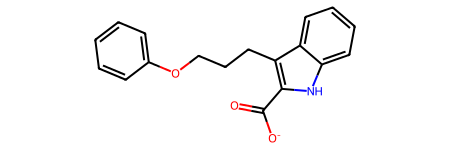

In [44]:
m

In [35]:
# Converting Indinavir from SMILES into a 3D PDB format
!obabel -ismi $ligandpath/lig27.smi -O lig27.mol2 #--gen3d best -p 7.4 --canonical
# Parameterizing and adding Gasteiger charges into our protein using MGLtools
# Adding -z leads to a rigid ligand without any torsions
# !prepare_ligand4.py -l lig27.mol2 -o $singlepath/lig27.pdbqt -U nphs_lps -v
# NOTE: for some reason, MGLtools does not recognize the ligand when inside a different folder
# Here we are deleting the temporary PDB file required for generating the PDBQT file
# os.remove("lig27.mol2")

obabel: cannot read input format!
Open Babel 2.4.1 -- Jan 25 2017 -- 17:44:52
Usage:
obabel [-i<input-type>] <infilename> [-o<output-type>] -O<outfilename> [Options]
Try  -H option for more information.


4. b) Use the program **babel** to  convert the SMILES into a 3D **MOL2** file while simultaneously performing and energy minimization using the Generalized Amber Force Field (**GAFF**). Then, use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges. Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [ ]:
# Converting lig27 from SMILES into a 3D MOL2 format and perform an energy minimization of the conformer using the GAFF forcefield
#Then, prepare ligand for docking using the Autodock script
!obabel $ligandpath/lig27.smiles -O lig27.mol2 --gen3d --best --canonical --minimize --ff GAFF --steps 10000 --sd
!prepare_ligand4.py -l lig27.mol2 -o $singlepath/lig27.pdbqt -U nphs_lps -v
os.remove("lig27.mol2")

4. c) Use the program **babel** to  convert the SMILES into a 3D **MOL2** file while simultaneously performing a weighted rotor search for the lowest energy conformer using the Generalized Amber Force Field (**GAFF**). Then, use **MGLtools** to parameterize the ligand using **Gasteiger** partial charges. Please note that we are generating a ligand in which **all torsions are active** during the docking procedure.

In [ ]:
# Converting lig27 from SMILES into a 3D MOL2 format and perform a weighted rotor search for lowest energy conformer
#Then, prepare ligand for docking using the Autodock script
!obabel $ligandpath/lig27.smiles -O lig27.mol2 --gen3d --best --canonical --conformers --weighted --nconf 50 --ff GAFF
!prepare_ligand4.py -l lig27.mol2 -o $singlepath/lig27.pdbqt -U nphs_lps -v
os.remove("lig27.mol2")

**You are all set with your ligand!** Now, we move onto setting up the molecular docking experiment

## 3. Setting up and Performing Molecular Docking with AutoDock

### 3.1. Defining the docking grid

As explained in the lectures, it is necessary to define the search space for molecular docking on a given target protein through the use of a **grid box**. This grid box is usually centred within the binding, active or allosteric site of the target protein and its size will be sufficiently large such that **all binding residues are placed inside the grid box**.

  Here, we will make use of **py3Dmol** to visually inspect the protein structure in cartoon representation and to draw a grid box. The position and size of the grid box will be defined by the coordinates of its centroid and by its dimensions in x, y and z.

  To better guide the search for the optimal dimensions and coordinates of the grid box, we will also show the residues Val32, Ile47 and Val82 of HIV-2 protease.

  The script that defines the visualizer, which we called **ViewProtGrid**, is first loaded into **Colab** with the following lines of code

In [ ]:
# @title Loading the script that creates our Docking Box Viewer
# These definitions will enable loading our protein and then
# drawing a box with a given size and centroid on the cartesian space
# This box will enable us to set up the system coordinates for the simulation
#
# HINT: The active site of the HIV-2 protease is near the beta strands in green
#
# ACKNOWLEDGE: This script is largely based on the one created by Jose Manuel
# Napoles Duarte, Physics Teacher at the Chemical Sciences Faculty of the
# Autonomous University of Chihuahua (https://github.com/napoles-uach)
#
# First, we define the grid box
def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

# Next, we define how the protein will be shown in py3Dmol
# Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile,resids):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'spectrum'}})
  object.addStyle({'resi':resids},{'stick':{'colorscheme':'greenCarbon'}})

# Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,1000,viewergrid=(1,2))
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile,resids)
  mol_view.setBackgroundColor('0xffffff')
  mol_view.rotate(90, {'x':0,'y':1,'z':0},viewer=(0,1));
  mol_view.zoomTo()
  mol_view.show()


### 3.2. Defining the viewpoint grid

Now, we will use our ViewProtGrid to visualize the protein, binding site residues and a grid box of variable size and position that we can manipulate using a slider through *ipywidgets*. You have to edit this viewer by indicating the location of the PDB file in the *prot_PDBfile* variable (e.g. singlepath/'4hw3_prot.pdb') and the residues that you want to show from the PDB in the *resids* variable.

### FIXME!!!
Examples of how to use the *protein_PDBfile* variable
>prot_PDBfile = ['4hw3_prot.pdb'] (if the PDB file is in the current path)

>prot_PDBfile = [singlepath/'4hw3_prot.pdb'] (if the PDB file is in a path defined as singlepath)


Examples of how to use the *resids* variable

>resids = [82] shows a single residue in position 82)

>resids = [82,83,84] shows residues 82, 83 or 84 separately, which you can select in the viewer

>resids = [(82,83,84)] shows residue 82, 83 and 84 in the same visualization

>resids = ['82-84'] shows residue range 82-84 in the same visualization

**NOTE:** This code fails when attempting to show two non-consecutive residues in the same visualization.


In [ ]:
# @title Loading the Docking Box viewer for a user-defined PDB input file and highlighted residues
from ipywidgets import interact,fixed,IntSlider
import ipywidgets

pdbfile = "" # @param {type:"string"}
resids = None # @param {type:"raw"}
interact(viewprotgrid,
# ADD YOUR PDB LOCATION AND FILENAME HERE
         prot_PDBfile = pdbfile,
# ADD THE RESIDUES YOU WANT TO VISUALIZE HERE
         resids = resids,
         bxi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         byi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bzi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bxf=ipywidgets.IntSlider(min=4,max=40, step=1),
         byf=ipywidgets.IntSlider(min=4,max=30, step=1),
         bzf=ipywidgets.IntSlider(min=4,max=30, step=1))

### 3.3.
 Now, we will generate a configuration file for **Autodock Vina**. As expected, the configuration file contains information about the target protein and ligand, as well as the position and dimensions of the grid box that defines the search space.

  For defining the grid box, you will use the  box origin and size coordinates that you defined manually in the previous step.

  The following is an example file of a standard **Autodock Vina configuration file**, including several possible variables that can be edited. A very relevant variable is the **exhaustiveness**, i.e., the number of independent runs starting from random conformations, and therefore the amount of computational effort during molecular docking.


```
#CONFIGURATION FILE

#INPUT OPTIONS
receptor = [target protein pdbqt file]
ligand = [ligand pdbqt file]
flex = [flexible residues in receptor in pdbqt format]

#SEARCH SPACE CONFIGURATIONS
#Center of the box (coordinates x, y and z
center_x = [value]
center_y = [value]
center_z = [value]
#Size of the box (dimensions in x, y and z)
size_x = [value]
size_y = [value]
size_z = [value]

#OUTPUT OPTIONS
#out = [output pdbqt file for all conformations]
#log = [output log file for binding energies]

#OTHER OPTIONS
cpu = [value] # more cpus reduces the computation time
exhaustiveness = [value] # search time for finding the global minimum, default is 8
num_modes = [value] # maximum number of binding modes to generate, default is 9
energy_range = [value] # maximum energy difference between the best binding mode and the worst one displayed (kcal/mol), default is 3
seed = [value] # explicit random seed, not required
```

The following script will create this file for our docking procedure. **You will need to add the position and dimensions of your grid box**


In [ ]:
#@title Generating an AutoDock Vina file
receptor = "" # @param {type:"string"}
ligand = "" # @param {type:"string"}
center_x = "" # @param {type:"string"}
center_y = "" # @param {type:"string"}
center_z = "" # @param {type:"string"}
size_x = "" # @param {type:"string"}
size_y = "" # @param {type:"string"}
size_z = "" # @param {type:"string"}
with open(singlepath / "config_singledock","w") as f:
  f.write("#CONFIGURATION FILE (options not used are commented) \n")
  f.write("\n")
  f.write("#INPUT OPTIONS \n")
  f.write("receptor = " + receptor +"\n")
  f.write("ligand = " + ligand +"\n")
  f.write("#flex = [flexible residues in receptor in pdbqt format] \n")
  f.write("#SEARCH SPACE CONFIGURATIONS \n")
  f.write("#Center of the box (values bxi, byi and bzi) \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX CENTER COORDINATES
  f.write("center_x = " + center_x + "\n")
  f.write("center_y = " + center_y + "\n")
  f.write("center_z = " + center_z + "\n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX DIMENSIONS
  f.write("#Size of the box (values bxf, byf and bzf) \n")
  f.write("size_x = " + size_x + "\n")
  f.write("size_y = " + size_y + "\n")
  f.write("size_z = " + size_z + "\n")
  f.write("#OUTPUT OPTIONS \n")
  f.write("#out = \n")
  f.write("#log = \n")
  f.write("\n")
  f.write("#OTHER OPTIONS \n")
  f.write("#cpu =  \n")
  f.write("#exhaustiveness = \n")
  f.write("#num_modes = \n")
  f.write("#energy_range = \n")
  f.write("#seed = ")

4. Lastly, we will enter into the folder that we created for the docking experiment and **perform our first molecular docking with Autodock Vina**.

  Once you execute the lines of code shown below, Autodock will show you a progress bar (if running as expected). **This simulation should not take longer than 5 min**.
  
  Note that we are defining the filenames of the output and log file outside the configuration file.

In [ ]:
#Changing directory to the single docking folder
os.chdir(singlepath)
#Executing AutoDock Vina with our configuration file
%vina --config config_singledock --out output.pdbqt | tee output.log
#Exiting the execution directory
os.chdir("/content/")

5. Once the molecular docking has finished running, we will compare the docking poses with the experimentally solved pose for indinavir. In fact, the structure of HIV-2 protease that you downloaded at the beginning of this tutorial was solved with indinavir bound to it.

  The following lines of code are similar to what we did with extracting the 'ATOM' lines of the PDB file, but now we are extracting the lines containing **'MK1'**, the name of the ligand in this PDB file.

In [ ]:
#Here, we will be extracting Indinavir, which is present in the structure of
#HIV-2 protease (yes! this is a simulation with experimental validation!)
#The approach is similar to printing the ATOM and TER lines, but we are using
#the residue name given to the ligand in the experimentally solved structure: MK1
protein = "1hsg.pdb"

with open(singlepath/"xtal_ligand.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if "MK1" in row:
      g.write(line)
  g.write("END")

6. We also need the different docking poses generated as a result of the molecular docking simulation. We will split these poses into separate PDB files using **babel**, starting with file numbered as 1 corresponding to the lowest-energy pose.

In [ ]:
#We need to convert our Autodock Vina results from pdbqt into pdb
#For this, we use babel
!obabel -ipdbqt $singlepath/output.pdbqt -opdb -O $singlepath/indinavir_dock.pdb -m

7. Finally, we will load our target protein into **py3Dmol**, along with any docking pose of our choice and the experimentally solved binding pose of indinavir for comparison.

In [ ]:
view=py3Dmol.view()
view.setBackgroundColor('white')
#Loading the target protein as PDB file
view.addModel(open(singlepath/'1hsg_prot.pdb', 'r').read(),'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
#Loading the docking pose
view.addModel(open(singlepath/'indinavir_dock1.pdb', 'r').read(),'pdb')
view.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
#Loading the experimentally solved binding mode
view.addModel(open(singlepath/'xtal_ligand.pdb', 'r').read(),'pdb')
view.setStyle({'resn':'MK1'},{'stick':{}})
view.show()

How similar is your docking pose when compared to the experimentally solved one?

**📚HOMEWORK:** Remember that redocking, i.e. a molecular docking simulation in which the ligand bound to the target is used as the starting conformation for the docking procedure, is commonly used as a control. Based on this information, plan a control simulation using the ligand that you just extracted in this tutorial

>```
>#Example of preparation of the experimentally solved ligand pose for redocking
>
>os.chdir(singlepath)
>!pythonsh /usr/local/bin/prepare_ligand4.py -l xtal_ligand.pdb -o $singlepath/xtal_ind.pdbqt -A hydrogens -U nphs_lps -v
>
>#Then, you can essentially use the same configuration files.
>```



**And this is the end of the sixth tutorial!** If you want to download your results, you can compress them into a zip file for manual download.

In [ ]:
### ADD for multiple ligands!
### What about plotting score v. experiment?
### Compute RMSD? -> MDAnalysis?

<div class="alert alert-success">
<b>Task 1:</b> Can you think of examples of features that you would find in molecular simulations?</div>

<details>
<summary> <mark> Solution: </mark> </summary>

Examples are:
- C-alpha positions
- angles
- dihedrals
- RMSD
- density
- surface area
- ...

</details>

In [ ]:
!zip -r singledocking.zip $singlepath
#By default, automatic download is enabled through the following lines
#but you need to disable your adblocker in order for it to work
from google.colab import files
files.download("/content/singledocking.zip")